Looking to plot linear, poly, and local weighted regression line on scatter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

In [25]:
data = pd.read_csv('abalone.data',header=None, nrows = 1000)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.sort_values(by='length', inplace=True)
data

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
236,I,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1
238,I,0.110,0.090,0.030,0.0080,0.0025,0.0020,0.0030,3
237,I,0.130,0.100,0.030,0.0130,0.0045,0.0030,0.0040,3
719,I,0.150,0.100,0.025,0.0150,0.0045,0.0040,0.0050,2
696,I,0.155,0.105,0.050,0.0175,0.0050,0.0035,0.0050,4
...,...,...,...,...,...,...,...,...,...
165,M,0.725,0.570,0.190,2.5500,1.0705,0.4830,0.7250,14
891,M,0.730,0.595,0.230,2.8255,1.1465,0.4190,0.8970,17
478,M,0.735,0.590,0.225,1.7560,0.6370,0.3405,0.5800,21
334,F,0.740,0.600,0.195,1.9740,0.5980,0.4085,0.7100,16


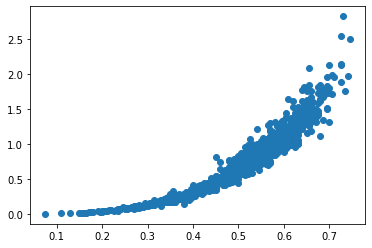

In [26]:
_X = np.array(data['length'])
_y = np.array(data['whole_weight'])
plt.scatter(_X, _y);

---

In [27]:
# adding feature intercept
_X_with_intercept = np.array([np.power(_X, p) for p in range(2)]).T

In [28]:
_X_with_intercept

array([[1.   , 0.075],
       [1.   , 0.11 ],
       [1.   , 0.13 ],
       ...,
       [1.   , 0.735],
       [1.   , 0.74 ],
       [1.   , 0.745]])

In [29]:
_Xt_X_inv = np.linalg.pinv(_X_with_intercept.T @ _X_with_intercept)
_Xt_y = _X_with_intercept.T @ _y
_beta = _Xt_X_inv @ _Xt_y
_beta

array([-0.99446296,  3.48551089])

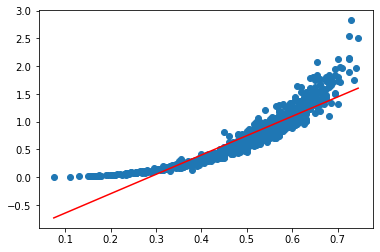

In [30]:
y_hat = _beta @ _X_with_intercept.T
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y);

---

In [31]:
# adding polynomial feature with intercept
def polynomial_degree(x, degree= 1):
    """
    returns polynomial features for one variable
    """
    
    array = np.array([np.power(x, p) for p in range(degree + 1)])
    
    return array.T

In [32]:
_X_poly = polynomial_degree(_X, 2)

In [33]:
_Xt_X_inv = np.linalg.pinv(_X_poly.T @ _X_poly)
_Xt_y = _X_poly.T @ _y
_beta = _Xt_X_inv @ _Xt_y
_beta

array([ 0.38285528, -3.07171752,  7.2131967 ])

In [34]:
_X_poly

array([[1.      , 0.075   , 0.005625],
       [1.      , 0.11    , 0.0121  ],
       [1.      , 0.13    , 0.0169  ],
       ...,
       [1.      , 0.735   , 0.540225],
       [1.      , 0.74    , 0.5476  ],
       [1.      , 0.745   , 0.555025]])

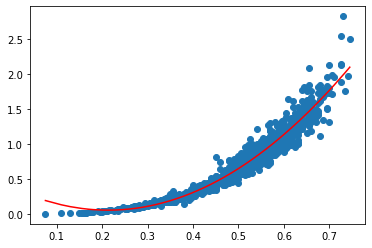

In [35]:
y_hat = _beta @ _X_poly.T
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y)

---

In [36]:
# weighted polynomial regression
_X_mat = np.mat(_X_poly)
_y_mat = np.mat(_y)

In [37]:
weights = np.mat(np.eye((len(_X_mat))))

In [38]:
for j in range(1000):
    # calculate difference off first entry
    diff = _X_mat[0] - _X_mat[j]
    weights[j, j] = np.exp(diff @ diff.T / (-2 * 0.05**2))
    
W = np.linalg.pinv(_X_mat.T * (weights * _X_mat)) * (_X_mat.T * weights * _y_mat.T)
y_hat = np.asarray(_X_mat * W).reshape(-1)

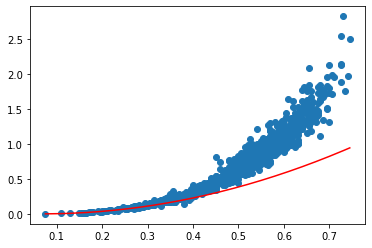

In [39]:
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y)

---

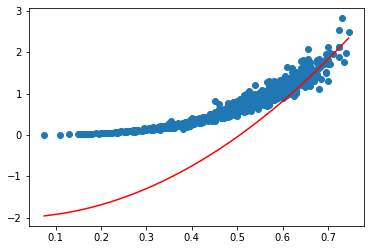

In [40]:
for j in range(1000):
    # calculate difference off last entry
    diff = _X_mat[-1] - _X_mat[j]
    weights[j, j] = np.exp(diff @ diff.T / (-2 * 0.05**2))
    
W = np.linalg.pinv(_X_mat.T * (weights * _X_mat)) * (_X_mat.T * weights * _y_mat.T)
y_hat = np.asarray(_X_mat * W).reshape(-1)
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y)

---

In [46]:
def kernel(point, xmat, k):
    m, n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    
    for j in range(m):
        diff = point - _X_mat[j]
        weights[j, j] = np.exp(diff * diff.T / (-2.0 * k**2))
        
    return weights


def localWeight(point, xmat, ymat, k):
    weight = kernel(point, xmat, k)
    
    W = (_X_mat.T * (weight*_X_mat)).I * (_X_mat.T * weight * ymat.T)
    return W


def localWeightRegression(xmat, ymat, k):
    m,n = np.shape(xmat)
    y_hat = np.zeros(m)
    
    for i in tqdm(range(m)):
        y_hat[i] = xmat[i] * localWeight(xmat[i], xmat, ymat, k)
        
    
        
    return y_hat
    
    
    

y_hat = localWeightRegression(_X_mat, _y_mat, 0.02)

100%|██████████| 1000/1000 [00:47<00:00, 21.11it/s]


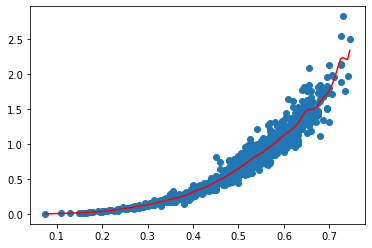

In [47]:
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y)